# Non-Maximum Suppression

In [4]:
def get_edge_localisation(self, method, dx=None, dy=None):
        epsilon = 0
        if method == GRADIENT:
            self.edge_localisation = np.zeros_like(dy)
            height, width = self.derived_filtered_img.shape

            for y in range(1, height - 1):
                for x in range(1, width - 1):
                    self.edge_localisation[y, x] = 0
                    if dy[y, x] != 0.0:
                        gradient_angle = np.arctan2(dy[y, x], dx[y, x]) * 180 / np.pi

                        y1, y2, x1, x2 = y, y, x, x

                        if (-22.5 <= gradient_angle < 22.5) or (157.5 <= gradient_angle <= 180) or (
                                -180 <= gradient_angle < -157.5):
                            (y1, y2) = (y - 1, y + 1) # Horizontal (0°)
                        elif (22.5 <= gradient_angle < 67.5) or (-157.5 <= gradient_angle < -112.5):
                            (y1, y2, x1, x2) = (y - 1, y + 1, x - 1, x + 1) # Diagonal 45° (upward)
                        elif (67.5 <= gradient_angle < 112.5) or (-112.5 <= gradient_angle < -67.5):
                            (x1, x2) = (x - 1, x + 1)  # Vertical (90°)
                        elif (112.5 <= gradient_angle < 157.5) or (-67.5 <= gradient_angle < -22.5):
                            (y1, y2, x1, x2) = (y - 1, y + 1, x + 1, x - 1)  # Diagonal -45° (downward)

                        if(self.derived_filtered_img[y1, x1] + epsilon < self.derived_filtered_img[y, x] and
                            self.derived_filtered_img[y2, x2] + epsilon < self.derived_filtered_img[y, x]):
                            self.edge_localisation[y, x] = 1
        else:
            zero_crossing_image = np.zeros_like(self.filtered_img)
            sign_img = np.sign(self.filtered_img)
            crossing_vertical = (np.roll(sign_img, 1, axis=0) * np.roll(sign_img, -1, axis=0) < 0)
            crossing_horizontal = (np.roll(sign_img, 1, axis=1) * np.roll(sign_img, -1, axis=1) < 0)
            zero_crossing_image[crossing_vertical] = 1
            zero_crossing_image[crossing_horizontal] = 1
            self.edge_localisation = zero_crossing_image

In [5]:
import torch
import torch.nn.functional as F
import numpy as np

def non_maximum_suppression_torch(image, edge_image, use_magnitude=True) -> torch.Tensor:
    """
    edge_image: torch.Tensor of shape [H, W], should be normalized (float32 or float64)
    returns: NMS-filtered edge image (same shape), float32 in range 0~1
    """

    if image.dtype != torch.float32:
        image = image.float()
    if edge_image.dtype != torch.float32:
        edge_image = edge_image.float()

    if image.max() > 1:
        image = image / 255.0
    if edge_image.max() > 1:
        edge_image = edge_image / 255.0

    # Add batch and channel dimensions: [1, 1, H, W]
    edge_image = edge_image.unsqueeze(0).unsqueeze(0)
    image = image.unsqueeze(0).unsqueeze(0)

    # Compute gradients with Sobel filters
    sobel_x = torch.tensor([[-1., 0., 1.],
                             [-2., 0., 2.],
                             [-1., 0., 1.]], device=edge_image.device)
    
    sobel_y = torch.tensor([[-1., -2., -1.],
                             [ 0.,  0.,  0.],
                             [ 1.,  2.,  1.]], device=edge_image.device)
    
    sobel_x = sobel_x.unsqueeze(0).unsqueeze(0)  # shape [1, 1, 3, 3]
    sobel_y = sobel_y.unsqueeze(0).unsqueeze(0)

    gx = F.conv2d(image, sobel_x, padding=1)
    gy = F.conv2d(image, sobel_y, padding=1)
    # gx = F.conv2d(edge_image, sobel_x, padding=1)
    # gy = F.conv2d(edge_image, sobel_y, padding=1)

    magnitude = torch.sqrt(gx ** 2 + gy ** 2)
    direction = torch.atan2(gy, gx) * 180 / np.pi
    direction = (direction + 180) % 180  # range: 0 ~ 180

    # Angle quantization (0, 45, 90, 135)
    angle = torch.zeros_like(direction)
    angle[(direction < 22.5) | (direction >= 157.5)] = 0
    angle[(direction >= 22.5) & (direction < 67.5)] = 45
    angle[(direction >= 67.5) & (direction < 112.5)] = 90
    angle[(direction >= 112.5) & (direction < 157.5)] = 135

    B, C, H, W = magnitude.shape
    suppressed = torch.zeros_like(magnitude)

    # Shifted versions of magnitude for comparison
    def shift(tensor, dx, dy):
        return F.pad(tensor, (1, 1, 1, 1), mode='replicate')[:, :, 1 + dy:H + 1 + dy, 1 + dx:W + 1 + dx]

    for a in [0, 45, 90, 135]:
        mask = (angle == a)

        if a == 0:
            q = shift(magnitude, 1, 0)
            r = shift(magnitude, -1, 0)
        elif a == 45:
            q = shift(magnitude, -1, -1)
            r = shift(magnitude, 1, 1)
        elif a == 90:
            q = shift(magnitude, 0, -1)
            r = shift(magnitude, 0, 1)
        elif a == 135:
            q = shift(magnitude, -1, 1)
            r = shift(magnitude, 1, -1)

        m = magnitude.clone()
        cond = (m >= q) & (m >= r)
        if use_magnitude:
            suppressed += m * cond * mask
        else:
            suppressed += edge_image * cond * mask

    return suppressed.squeeze(0).squeeze(0).clamp(0, 1)


# 应用

In [6]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.morphology import thin

project_root = Path("/home/yangk/intership_2025_COSYS")

# 读取图片并转换为Tensor（灰度图）
# image = Image.open(project_root / "resource/Lucas/images/sines-targets/Sine1D.jpg" ).convert("L")
org_image = Image.open(project_root / "resource/DexiNed/BIPEDv2/BIPED/edges/imgs/test/rgbr/RGB_008.jpg" )
edge = Image.open(project_root / "resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/RGB_008.png" )
transform = T.ToTensor()
edge_tensor = transform(edge.convert("L"))[0]  # shape [H, W]
img_tensor = transform(org_image.convert("L"))[0]  # shape [H, W]

# 应用 NMS
canny_result = non_maximum_suppression_torch(img_tensor, edge_tensor)
nms_result_without_org = non_maximum_suppression_torch(edge_tensor, edge_tensor, use_magnitude=False)
nms_result_with_org = non_maximum_suppression_torch(img_tensor, edge_tensor, use_magnitude=False)
thin_result = thin(edge_tensor>0.9)


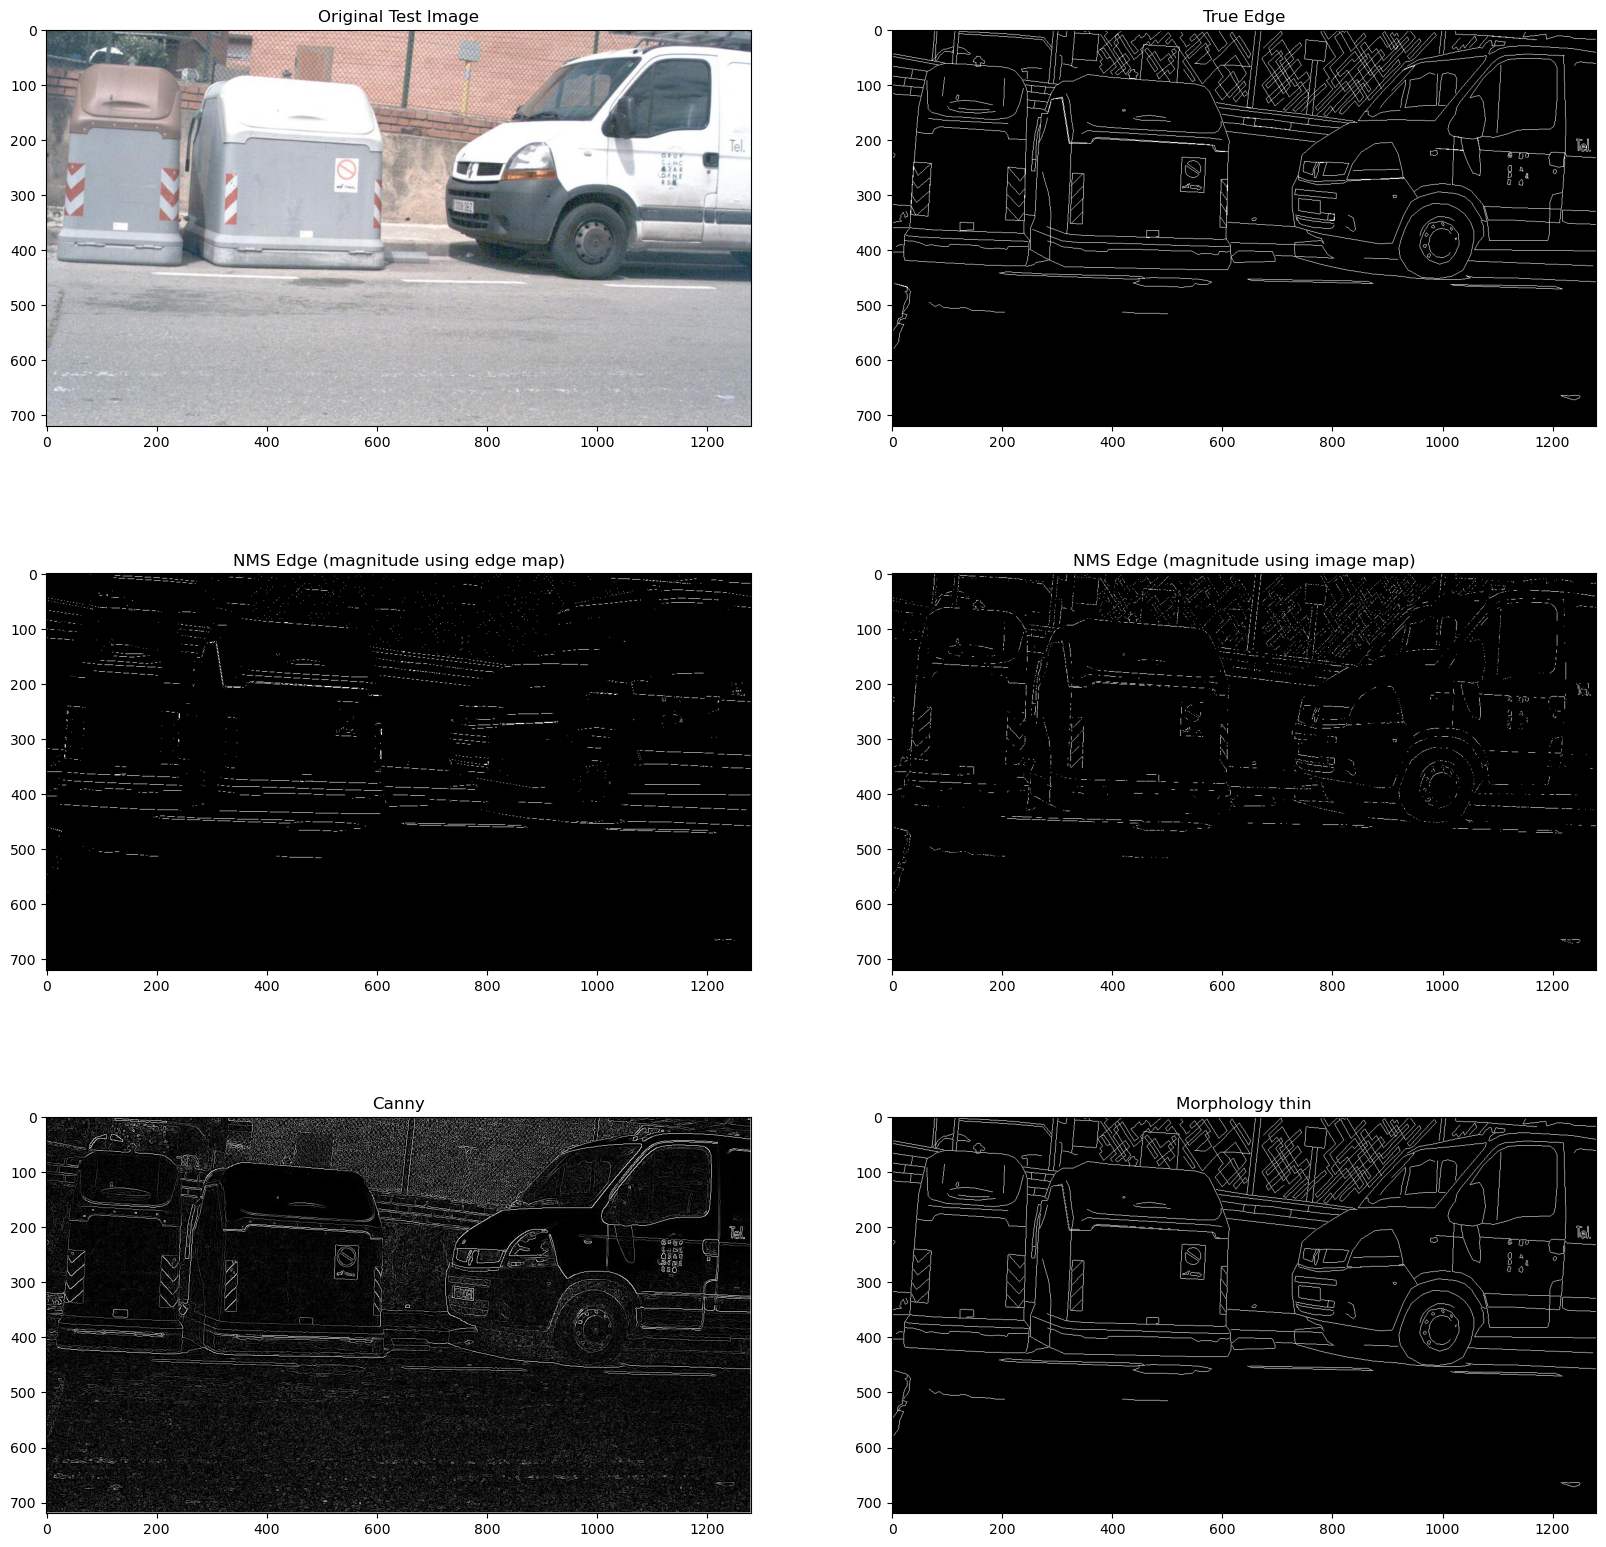

In [7]:
# 显示原图和边缘图
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs[0,0].imshow(org_image)
axs[0,0].set_title("Original Test Image")

axs[0,1].imshow(edge, cmap="gray")
axs[0,1].set_title("True Edge")

axs[1,0].imshow(nms_result_without_org.cpu().numpy(), cmap="gray")
axs[1,0].set_title("NMS Edge (magnitude using edge map)")

axs[1,1].imshow(nms_result_with_org.cpu().numpy(), cmap="gray")
axs[1,1].set_title("NMS Edge (magnitude using image map)")

axs[2,0].imshow(canny_result.cpu().numpy(), cmap='gray')
axs[2,0].set_title("Canny")

axs[2,1].imshow(thin_result, cmap='gray')
axs[2,1].set_title("Morphology thin")

plt.show()

# 应用于模型输出看看

## 加载模型

In [8]:
import sys
import json
# 把 Dexined 加入 sys.path
model_dir = project_root / "resource/DexiNed"
if str(model_dir) not in sys.path:
    sys.path.append(str(model_dir))
from model import DexiNed

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DexiNed()
logging = {
    'metadata': {},
    'train_loss': [],
    'val_loss': []
}
# load model
model.load_state_dict(torch.load(project_root / "demo/demo_Dexined/checkpoints/cpt_visibility_04.pth", weights_only=True))
# load log
with open(project_root / "demo/demo_Dexined/checkpoints/cpt_visibility_04.json", 'r') as f:
    logging = json.load(f)
logging['metadata']

{'description': 'More crazy!!! 200 epoch',
 'num_epoch': 200,
 'batch_size': 8,
 'criterion': 'MSELoss',
 'learning_rate': 0.0001}

## 加载测试集

In [10]:
import sys
# 把 src 加入 sys.path
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.append(str(src_dir))
from dataset import BIPEDv2

data_dir = project_root / "resource/DexiNed/BIPEDv2/BIPED/edges"
test_dataset = BIPEDv2(
    data_dir / "imgs" / "test" / "rgbr",
    data_dir / "edge_maps" / "test" / "rgbr"
)

## inference出一张图

In [11]:
img = test_dataset[0]
x = img['image_tensor']
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

In [12]:
import numpy as np
def normalisation(img, threshold=100):
    res = img / threshold
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res) 
    return res

In [13]:
org_image = Image.open(img['image_path'] )
edge = Image.open(img['edge_path'] )
transform = T.ToTensor()
# edge_tensor = transform(edge.convert("L"))[0]  # shape [H, W]
img_tensor = transform(org_image.convert("L"))[0]  # shape [H, W]


gt_display = normalisation(img['visibility_map'])
pred_display = normalisation(yhat)
pred_nms_display = normalisation(non_maximum_suppression_torch(yhat, yhat, use_magnitude=False))
pred_nms_with_org_display = normalisation(non_maximum_suppression_torch(img_tensor, yhat, use_magnitude=False))

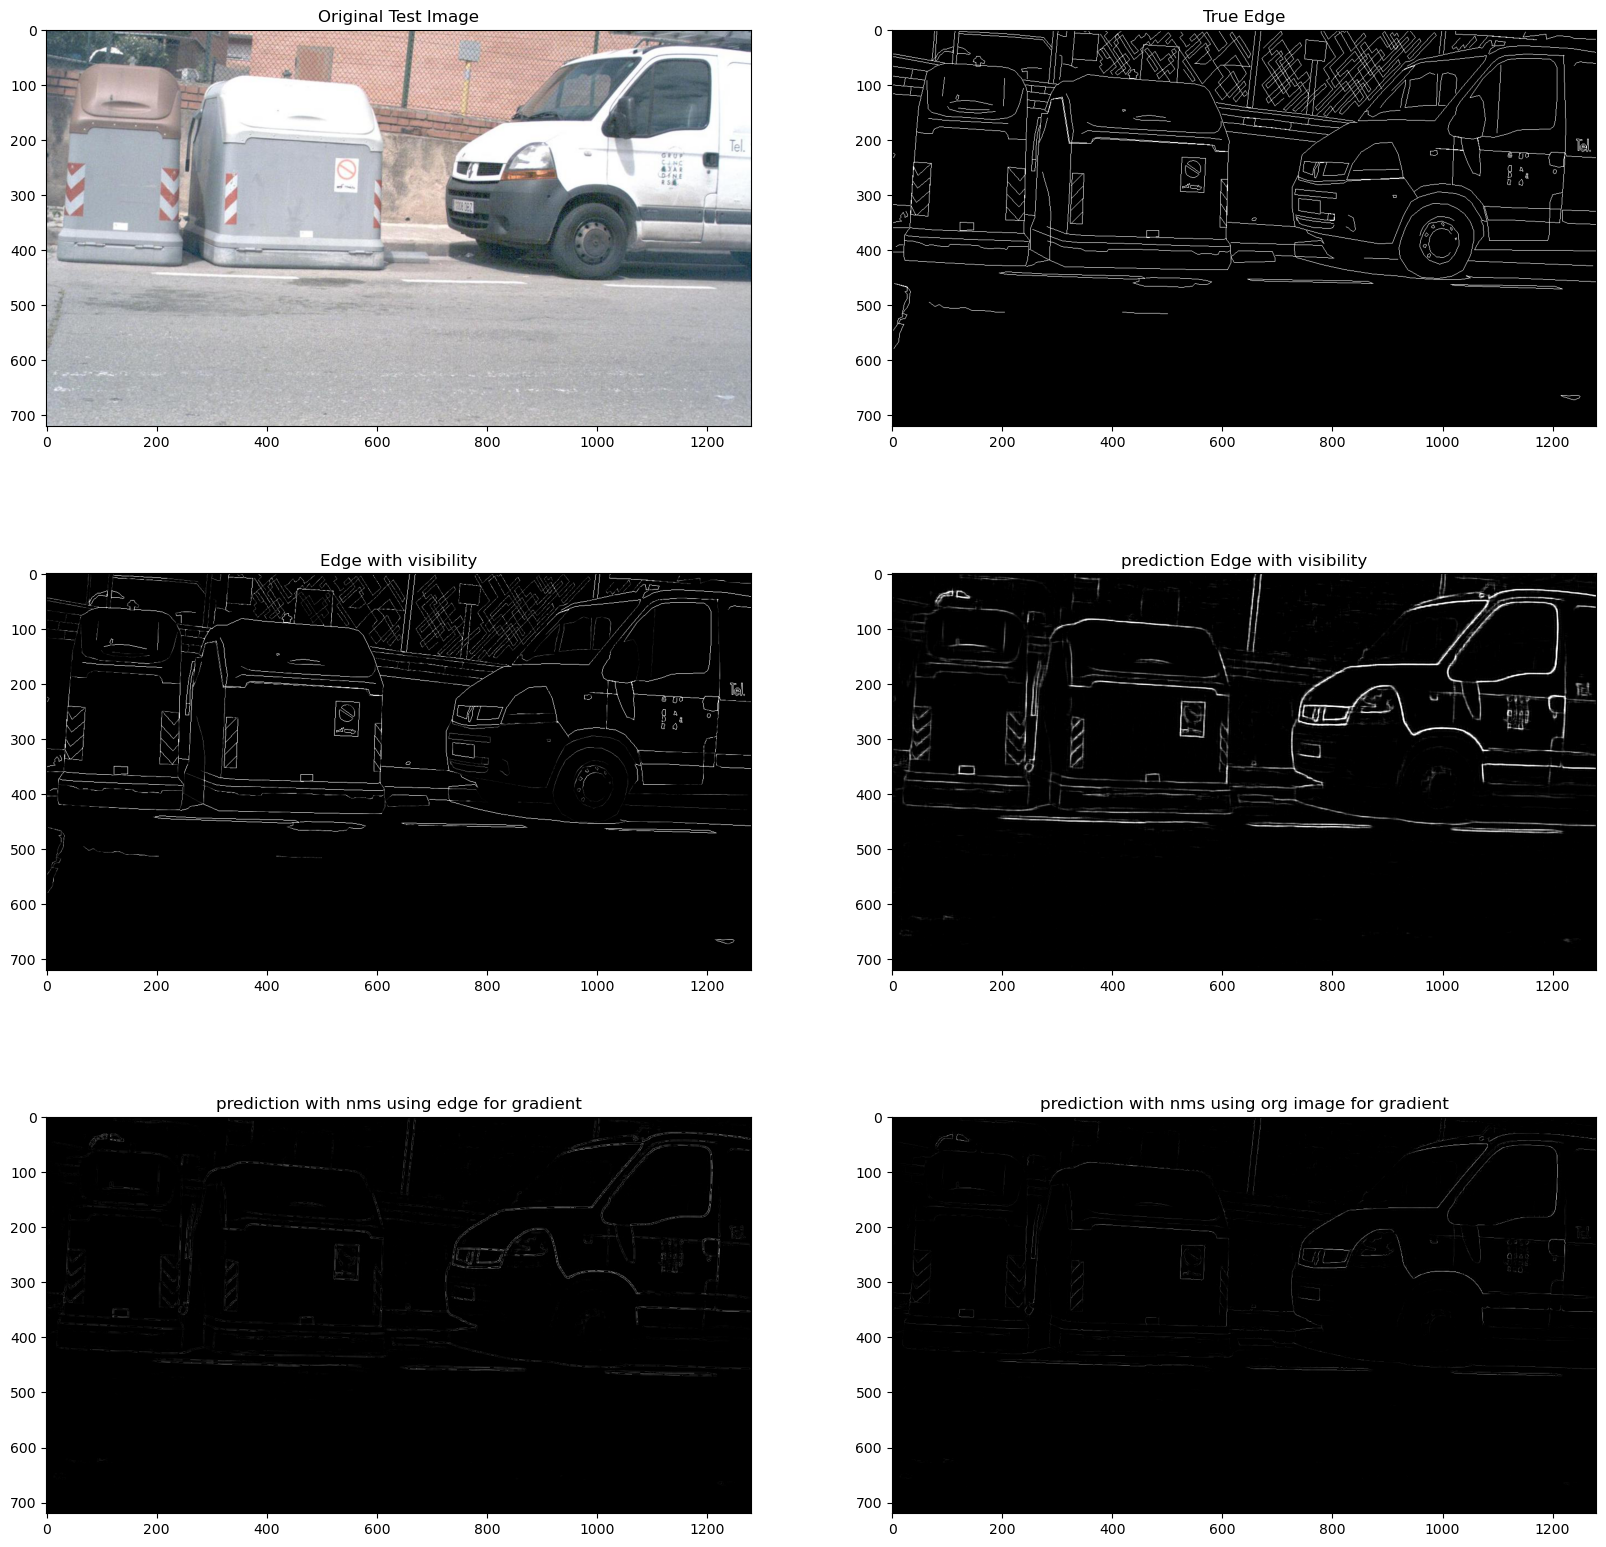

In [14]:
# 显示原图和边缘图
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs[0,0].imshow(org_image)
axs[0,0].set_title("Original Test Image")

axs[0,1].imshow(edge, cmap="gray")
axs[0,1].set_title("True Edge")

axs[1,0].imshow(gt_display, cmap="gray")
axs[1,0].set_title("Edge with visibility")

axs[1,1].imshow(pred_display, cmap="gray")
axs[1,1].set_title("prediction Edge with visibility")

axs[2,0].imshow(pred_nms_display, cmap='gray')
axs[2,0].set_title("prediction with nms using edge for gradient")

axs[2,1].imshow(pred_nms_with_org_display, cmap='gray')
axs[2,1].set_title("prediction with nms using org image for gradient")

plt.show()

In [15]:
# x = 

# pred_nms_display = normalisation(non_maximum_suppression_torch(yhat, yhat, use_magnitude=False))
# pred_nms_with_org_display = normalisation(non_maximum_suppression_torch(img_tensor, yhat, use_magnitude=False))

In [19]:
yhat

tensor([[-4.1668e+00, -5.4080e+00, -2.3093e+00,  ..., -5.9624e+00,
         -7.1805e+00, -9.2635e+00],
        [-4.9979e+00, -5.6175e+00, -3.0904e+00,  ..., -6.7822e+00,
         -9.0479e+00, -1.0231e+01],
        [-1.5439e+00, -2.5679e+00,  9.8348e-03,  ...,  7.5066e+00,
         -5.2255e+00, -9.5784e+00],
        ...,
        [-2.3404e+00, -2.7831e+00,  7.5105e-03,  ...,  3.5454e-02,
          2.3569e-02,  3.6158e-02],
        [-2.8964e-01, -7.7552e-01, -5.3092e-01,  ...,  4.8914e-02,
          3.6389e-02,  4.3435e-02],
        [-3.1312e-01, -6.1082e-01, -6.0469e-01,  ...,  7.5350e-02,
          4.4175e-02,  7.3135e-02]])

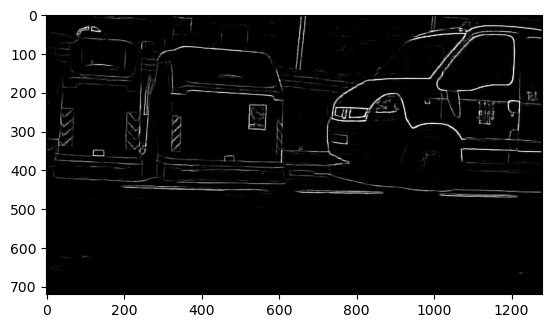

In [25]:
plt.imshow(pred_display, cmap="gray")
plt.savefig("/home/yangk/intership_2025_COSYS/output_pred_display.png")

In [42]:
import cv2
import numpy as np

# 示例：创建一个 100x100 的灰度图（中灰色）
# gray_image = np.full((100, 100), 128, dtype=np.uint8)  # 值范围：0（黑）到 255（白）

# 保存为 PNG
image_to_save = pred_nms_display
image = np.zeros_like(image_to_save, dtype=np.uint8)
image[:] = image_to_save * 255 * 255  # 注意：OpenCV 用的是 BGR 顺序
cv2.imwrite("/home/yangk/intership_2025_COSYS/prediction_with_nms_using_edge_for_gradient_carré.png", image)


True

In [37]:
image_to_save.max()

0.0078010834

In [38]:
non_maximum_suppression_torch(yhat, yhat, use_magnitude=False).max()

tensor(0.7801)

In [39]:
yhat.max()

tensor(272.3696)